# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
import os
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image
#Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [3]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.2M  100 10.2M    0     0  10.2M      0  0:00:01 --:--:--  0:00:01 52.1M


In [4]:
#mtaRides = np.load("MTA_Fare.npy")

In [5]:
os.system("mv " + "MTA_Fare.npy " + os.getenv("PUIDATA"))

0

In [6]:
mtaRides = np.load(os.getenv('PUIDATA') + '/' + 'MTA_Fare.npy')

In [7]:
#after reading the datacube you should see:
mtaRides.shape

(600, 23, 194)

In [8]:
dates = pd.date_range('5/21/2010', periods=194, freq='W')

In [9]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [10]:
print ridetype

['10t' '14d' '1d' '2t' '30d' '7d' 'ada' 'afas' 'exp' 'ez' 'ff' 'mc' 'mr'
 'month' 'rfm' 'rr' 'sen' 'spec' 'tcmc' 't' 'umlim' 'xbus' 'stud']


## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [11]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRides.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_all = np.nansum(mta_allsum, axis=0)
print (mta_all.shape)

(600, 23, 194)
(23, 194)
(194,)


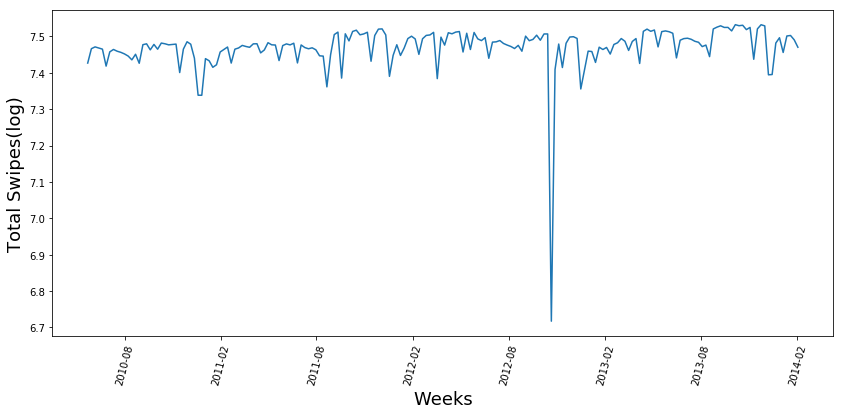

In [12]:
pl.figure(figsize=(14, 6))
pl.xlabel("Weeks", fontsize = 18)
pl.ylabel("Total Swipes(log)", fontsize = 18) 

pl.xticks(rotation=75)
#pl.ylim(-20, pl.ylim()[1])
#pl.legend(fontsize=20)

pl.plot(dates, np.log10(mta_all));

### Fig 1. All 600 subways stations, all 23 card types from 05/21/2010 to 02/21/2014

In [13]:
print ("mean # of swipes by week = {:.2f} ".format(mta_all.mean()))
print ("stdev swipes by day = {:.2f}".format(mta_all.std()))
thresholds = [mta_all.mean() + 3 * mta_all.std(), 
              mta_all.mean() - 3 * mta_all.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ("earliest datapoint", min(dates))

mean # of swipes by week = 29778001.61 
stdev swipes by day = 2984034.35
3-sigma thresholds 38730104.65 20825898.56
('earliest datapoint', Timestamp('2010-05-23 00:00:00', offset='W-SUN'))


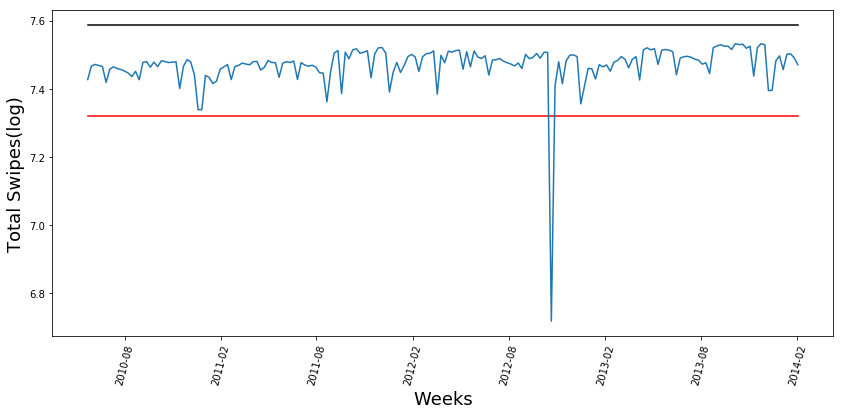

In [14]:
pl.figure(figsize=(14, 6))
pl.xlabel("Weeks", fontsize = 18)
pl.ylabel("Total Swipes(log)", fontsize = 18) 

pl.xticks(rotation=75)
#pl.ylim(-20, pl.ylim()[1])
#pl.legend(fontsize=20)

pl.plot((min(dates), max(dates)),(np.log10(thresholds[0]),np.log10(thresholds[0])), color='black')
pl.plot((min(dates), max(dates)),(np.log10(thresholds[1]),np.log10(thresholds[1])), color='r')

pl.plot(dates, np.log10(mta_all));

### Fig 2. All 600 subways stations, all 23 card types from 05/21/2010 to 02/21/2014. Including thresholds of +3 std and -3 std

In [15]:
mta_all.argmin()

126

In [16]:
print (dates[np.where(mta_all < 20825898.56)])

DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


### From the first graph one can see an event happened on the fall of 2012. If we use the np.where function we can see the exact date is October 21st 2012.  By doing some research we can confirm around these dates is when Hurricane Sandy hit NYC

https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_New_York

### It was exactly on Oct 28th that subway was suspended

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

### NOTE ON THE TREND DETECTION:
you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [17]:
dates_D = pd.date_range(start ='5/28/2010', periods=194 , freq='7D')
dates_D

DatetimeIndex(['2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
               '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
               '2010-07-23', '2010-07-30',
               ...
               '2013-12-06', '2013-12-13', '2013-12-20', '2013-12-27',
               '2014-01-03', '2014-01-10', '2014-01-17', '2014-01-24',
               '2014-01-31', '2014-02-07'],
              dtype='datetime64[ns]', length=194, freq='7D')

In [18]:
#mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)

(23, 194)


In [19]:
mta_rideType = pd.DataFrame(mta_allsum, index=ridetype ).T
mta_rideType.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494477,530386,47663,186413,46670,3697305,8551799,9925,333059,511894,...,122996,789972,59671,28083,-138,124555,20922,5990,220,-600
1,12526720,583394,51347,199090,64214,3981669,9486255,11708,282616,577884,...,151809,907929,69070,32194,-139,121574,21531,5981,335,-600
2,12766490,586057,51499,199531,56857,4032893,9476401,12140,301891,615400,...,151401,913987,69437,32481,-137,122044,21296,6353,328,-600
3,12653538,562465,51926,196252,37292,4032616,9449944,11084,305376,606133,...,146957,902412,67962,32267,-137,121914,21493,6453,347,-600
4,12809558,548722,51017,194747,35074,3925310,9293866,10379,335644,563310,...,137752,855437,66241,31797,40,119640,20161,6177,316,-600


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


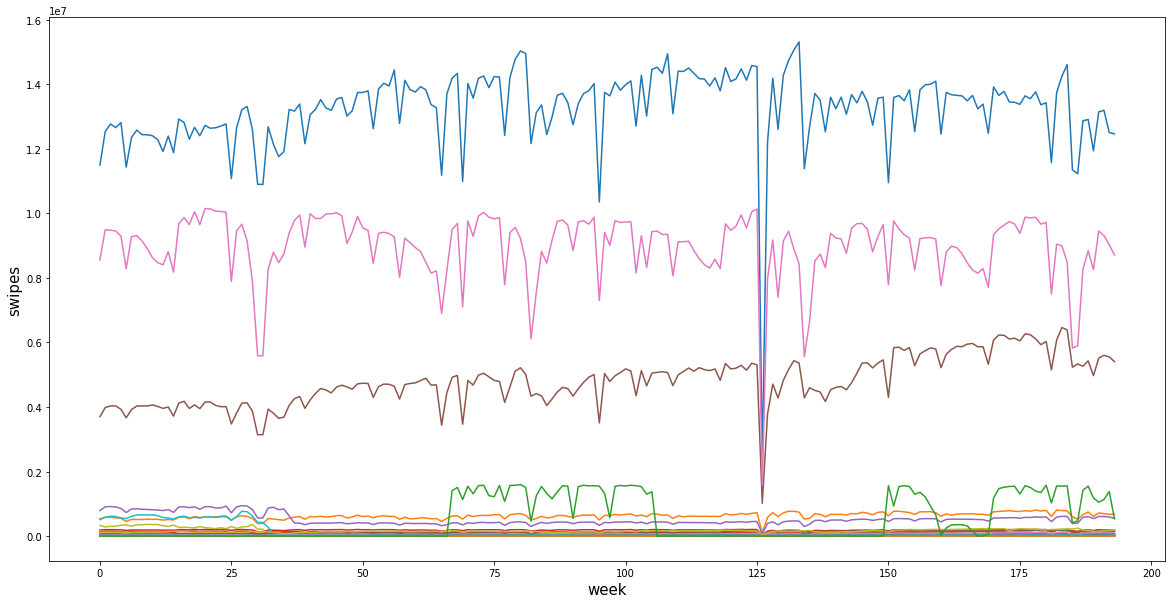

In [20]:
plt.figure(figsize=(20,10))
plt.plot(mta_rideType)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('week', fontsize=15)
plt.ylabel('swipes', fontsize=15)

### Fig3 the swipes of the 23 ride types along the 194 weeks

In [21]:
mta_rideType_start = pd.rolling_mean(mta_rideType, 10).iloc[9:19].apply(lambda x: np.mean(x))
mta_rideType_end = pd.rolling_mean(mta_rideType, 10).iloc[-10:].apply(lambda x: np.mean(x))

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


In [22]:
mta_rideType_ratio = mta_rideType_start/mta_rideType_end

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f262125ef10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f25b286c5d0>]], dtype=object)

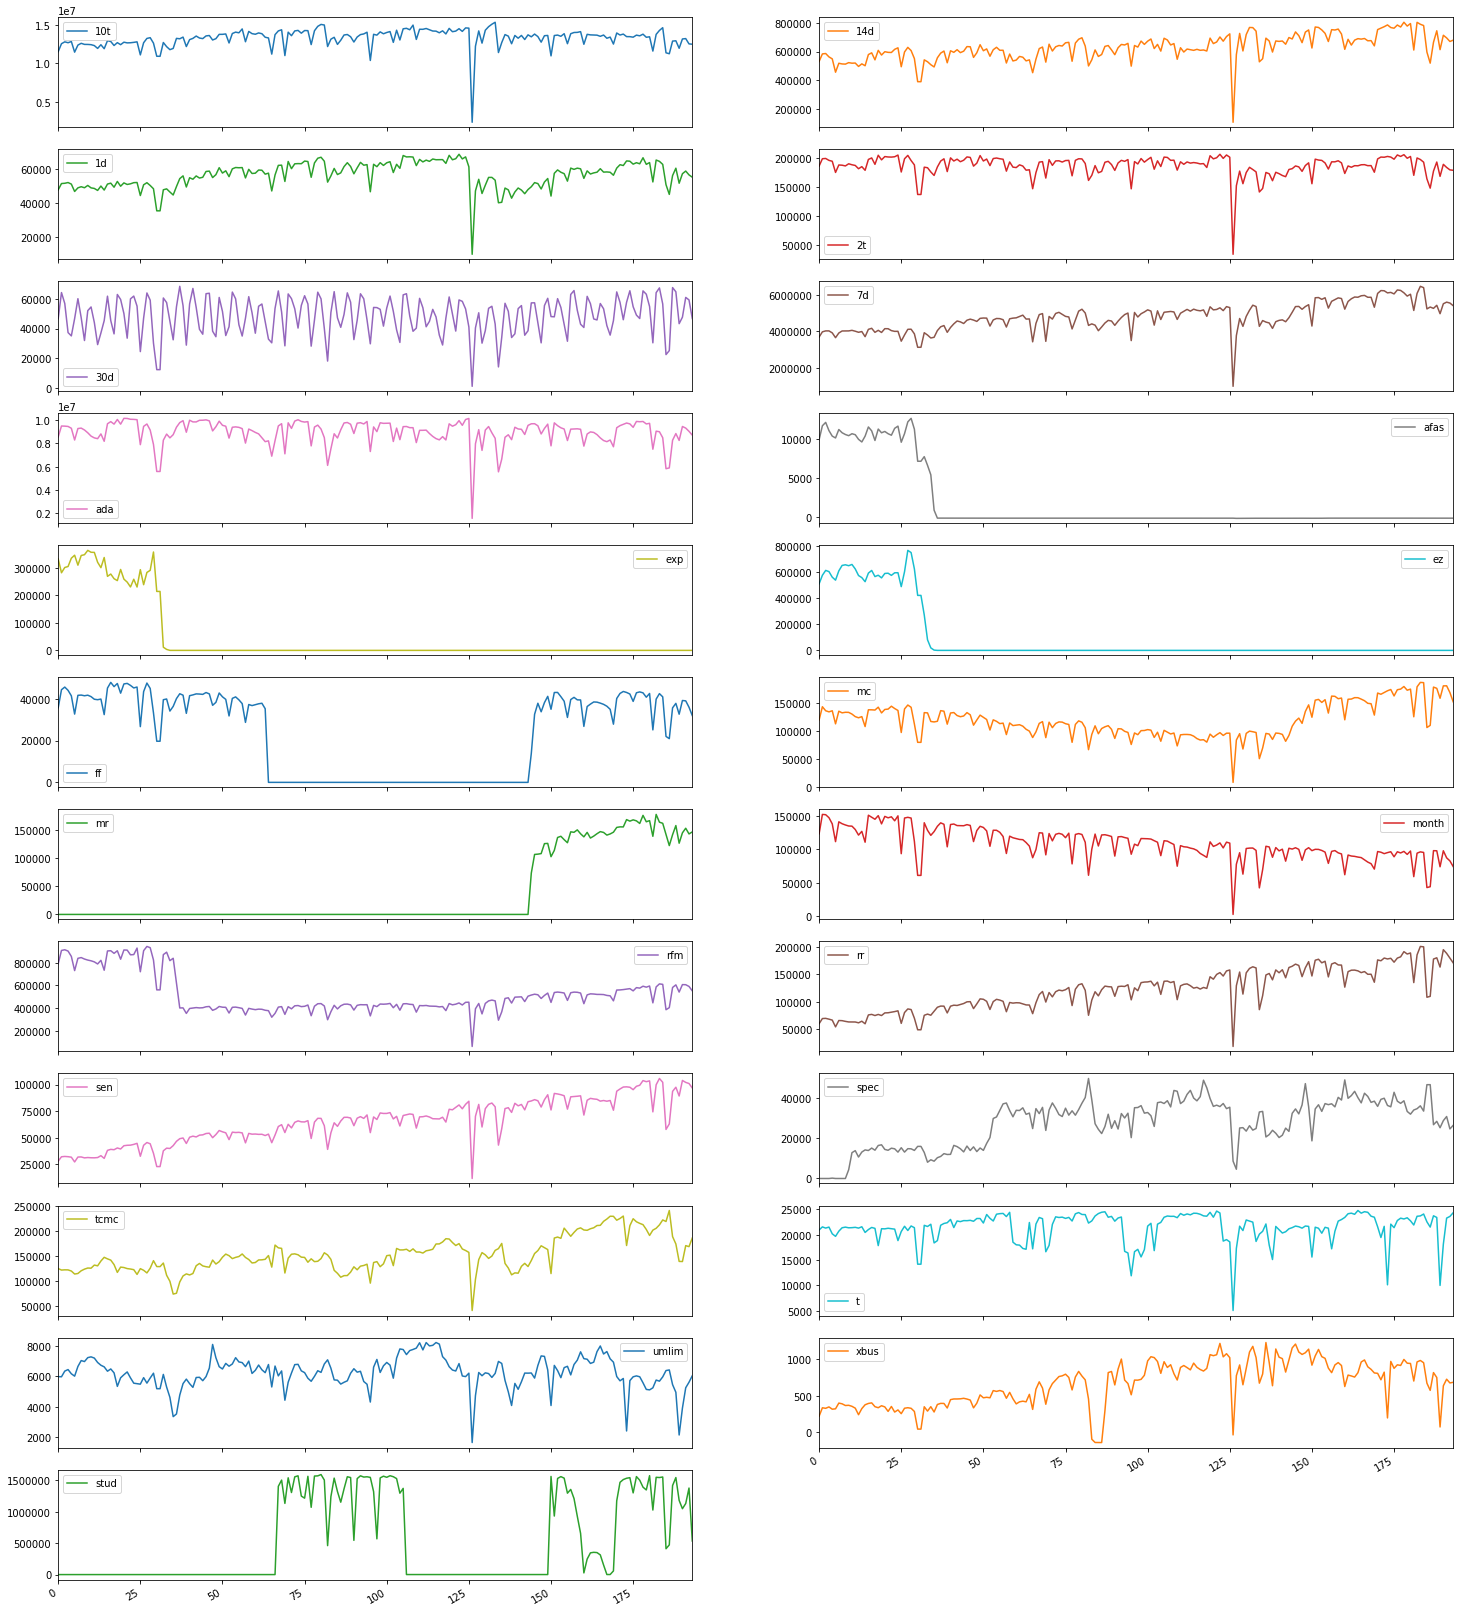

In [23]:
mta_rideType.plot(subplots= True, layout=(15,2), figsize=(25,40))

### Fig 4: the trends for all 23 ride types

In [24]:
#droping the ones with zero
mta_rideType_ratio.drop(['afas', 'exp', 'ez', 'ff', 'mr', 'stud', 'spec']).sort_values()

sen      0.350355
rr       0.379641
xbus     0.443563
tcmc     0.631292
7d       0.693384
14d      0.740073
mc       0.799850
1d       0.846549
30d      0.893704
t        0.948232
10t      0.952452
2t       1.017479
ada      1.067422
umlim    1.239639
rfm      1.512243
month    1.620672
dtype: float64

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


(0, 202.19999999999999)

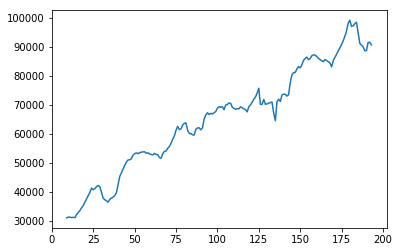

In [25]:
mta_rideType_rolling = pd.rolling_mean(mta_rideType, 10)

pl.plot((mta_rideType_rolling.sen))
pl.xlim(xmin = 0)

### Fig 5: Ride type with the biggest increase over time

(0, 202.19999999999999)

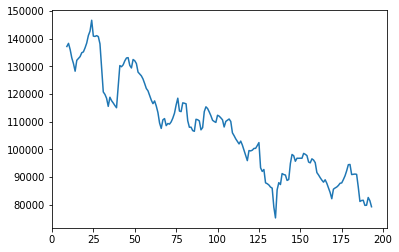

In [26]:
pl.plot((mta_rideType_rolling.month))
pl.xlim(xmin = 0)

### Fig 6: Ride type with the biggest decrease over time

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [27]:
print (mtaRides.shape)
mta_stations = np.nansum(mtaRides, axis=1)
print (mta_stations.shape)

(600, 23, 194)
(600, 194)


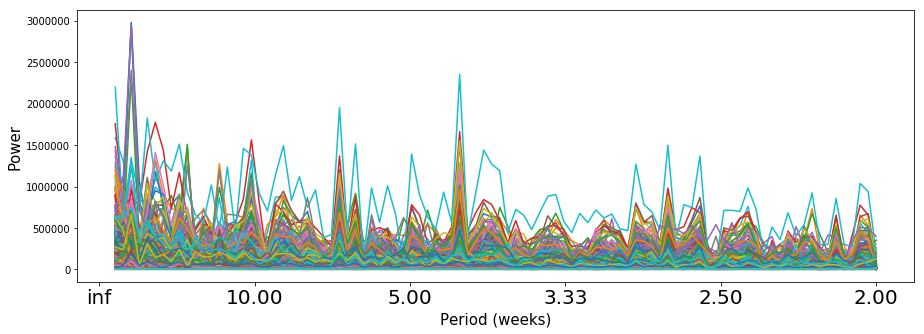

In [28]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

N = 194

for i in range(len(mta_stations)):
    f = np.abs(np.fft.rfft(mta_stations[i]))
    ax.plot(np.fft.rfftfreq(N,1.0)[2:], f[2:], '-')

ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

### Fig7: Power spectrum of the 600 stations. We can visually see some periodicity, by some very obvious spikes in power.

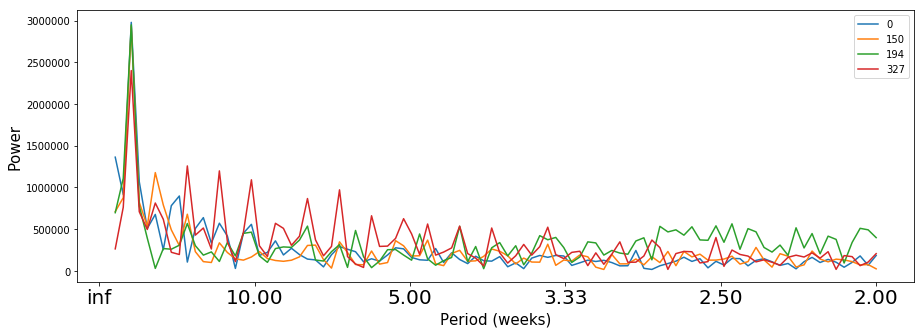

In [29]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

N = 194

for i in range(len(mta_stations)):
    f = np.abs(np.fft.rfft(mta_stations[i]))
    if f[2:].max() > 2400000:
        ax.plot(np.fft.rfftfreq(N,1.0)[2:], f[2:], '-', label=i)
        pl.legend()
        

ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

### Fig8: Power spectrum of the 4 more periodic stations.

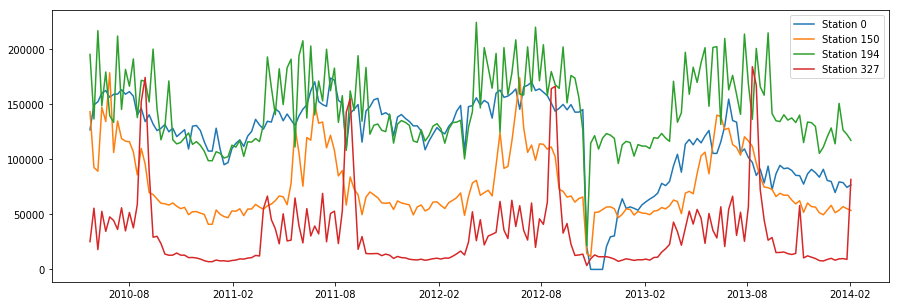

In [30]:
# Plotting number of swipes for each of the 4 stations

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

ax.plot(dates, mta_stations[0], label='Station 0')
ax.plot(dates, mta_stations[150], label='Station 150')
ax.plot(dates, mta_stations[194], label='Station 194')
ax.plot(dates, mta_stations[327], label='Station 327')

pl.legend()


### Figure9: We can see the 4 stations that have a very clear periodicity. The number of swipes is higher during the warmer months, and in particular towards the end if the "high season" there appears to be a spike, in particular in station 327. This could be perhaps to a very popular space for labor day weekend.




## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```